In [12]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import numpy as np
from scipy import stats
import pymc3 as pm

In [13]:
data = np.repeat([1, 0], [11, 3])

In [14]:
# Define the Bernoulli likelihood function, p(D|theta).
# The argument theta could be a vector, not just a scalar.
def likelihood(theta, data):
    theta = np.array(theta)
    z = sum(data) # Finding all the heads in the dataset
    N = len(data)
    
    p_data_given_theta = np.array(
        np.power(theta, z) * np.power((1-theta), N-z)
    )
    p_data_given_theta[(theta > 1) | (theta < 0)] = 0.0
    return p_data_given_theta

In [15]:
# Define the prior density function
# For the current problem, this will be a uniform density prior
# over the interval [0,1].
# The argument `theta` could be a vector, not just a scalar.
def prior(theta):
    theta = np.array(theta)

    prior = np.ones(np.size(theta))
    
    prior[(theta > 1) | (theta < 0)] = 0.0
    
    return prior

In [16]:
# Define the relative probability of the target distribution
# as a fnction of vector theta. For our application, this
# target distribution is the unnormalized posterior distribution.

def target_rel_prob(theta, data):
    target_rel_prob = likelihood(theta, data) * prior(theta)
    
    return target_rel_prob

In [17]:
# Specify the length of the trajectory i.e the number of jumps to try:
traj_length = 5000
# Intialize the vector that will store the results
trajectory = np.zeros(traj_length)
# Specify where to start the trajectory
trajectory[0] = 0.001 # arbitary value
# Specify the burn-in period:
burn_in = int(np.ceil(0.1 * traj_length))
# Intialize accepted and rejected counters, just to monitor performance
n_accepted = 0
n_rejected = 0

In [18]:
# Now generate the random walk. The 't' index is time or trial in 
# the walk. Specift seed to reproduce the same ran dom walk:

np.random.seed(47405)


In [19]:
# Specify standard deviation for the proposal distribution
proposal_sd = [0.02, 0.2, 2.0][1]

In [20]:
for t in range(0, traj_length-1):
    current_position = trajectory[t]
    # Use the proposal distribution to generate a proposed jump.
    proposed_jump = np.random.normal(loc=0, scale=proposal_sd)
    # Compute the probability of accepting the proposed jump.
    prob_accept = min(
        1,
        target_rel_prob(current_position + proposed_jump, data)/target_rel_prob(current_position, data)
    )
    if np.random.rand() < prob_accept:
        # accept the proposed jump
        trajectory[t+1] = current_position + proposed_jump
        if (t > burn_in):
            n_accepted = n_accepted + 1
    else:
        trajectory[t+1] = current_position
        if (t > burn_in):
            n_rejected = n_rejected + 1

In [21]:
accepted_traj = trajectory[(burn_in + 1): len(trajectory)]
# --------------------------------------------------------
# ------------------ End of Metropolis algorithm ---------
# --------------------------------------------------------

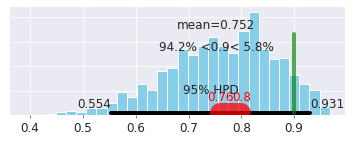

In [22]:
ROPE = np.array([0.76, 0.8])
pm.plot_posterior(accepted_traj,  ref_val=0.9, rope=ROPE)
plt.xlabel = 'theta'

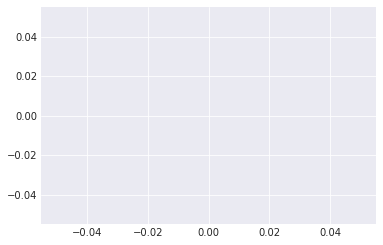

In [23]:
# Display rejected/accepted ratio in the plot.
mean_traj = np.mean(accepted_traj)
std_traj = np.std(accepted_traj)
plt.plot(0, label=r'$N_{pro}=%s$ $\frac{N_{acc}}{N_{pro}} = %.3f$' % (len(accepted_traj), (n_accepted/len(accepted_traj))), alpha=0)

# Evidence for model, p(D).

# Compute a,b parameters for beta distribution that has the same mean
# and stdev as the sample from the posterior. This is a useful choice
# when the likelihood function is Bernoulli.
a =   mean_traj   * ((mean_traj*(1 - mean_traj)/std_traj**2) - 1)
b = (1 - mean_traj) * ((mean_traj*(1 - mean_traj)/std_traj**2) - 1)

# For every theta value in the posterior sample, compute 
# dbeta(theta,a,b) / likelihood(theta)*prior(theta)
# This computation assumes that likelihood and prior are proper densities,
# i.e., not just relative probabilities. This computation also assumes that
# the likelihood and prior functions were defined to accept a vector argument,
# not just a single-component scalar argument.
wtd_evid = stats.beta.pdf(accepted_traj, a, b) / (likelihood(accepted_traj, data) * prior(accepted_traj))
p_data = 1 / np.mean(wtd_evid)


# Display p(D) in the graph
plt.plot(0, label='p(D) = %.3e' % p_data, alpha=0)


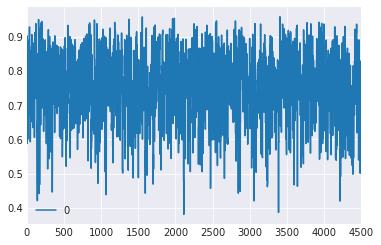

In [30]:
import pandas as pd

pd.DataFrame(accepted_traj).plot()

In [32]:
from statsmodels.graphics.tsaplots import plot_acf

Figure(432x288)


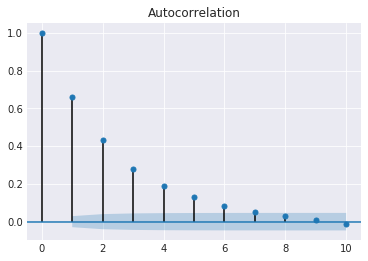

In [39]:
print(plot_acf(accepted_traj, lags=10))